# Classifying Jobs by Title using Natural Language Processing

Understanding the availability of jobs is important in determining which positions to feature in ads, who to target, where to target them, and which platforms to target them on.

As discussed in the Job Listing EDA notebook, labeling jobs by role or company can be error prone. Instead, learning patterns which are common in a certain type of job and applying a label automatically may be helpful. Especially when dealing with over 10M jobs each day. 

Here, we look at basic NLP approaches to classify jobs by title. For simplicity, we only consider whether a job is a skilled position (nurses, engineers, consultants) or a gig-role (drivers, cashiers, shoppers).

We are primarily interested in identifying and isolating gig-jobs. These roles are more suitable for advertising through social media platforms and tend to have high click rates.

More complex approaches are certainly interesting. But this first approach demonstrates the power of even the simplest models.

In [2]:
import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Labelling Training Data

While it is certainly possible to look at clustering methods to separate jobs by type, since we only care about two classes, it is much easier to manually label a subset of the data and begin training a simple model. If this proves useful, we can then direct our attention to more involved methods.

For the time being, we labelled 1000 job samples from one feed. The production model will sample each feed daily to prepare a small subset of data which can be re-labeled and fed back to the model to re-train it as more data becomes available.

Considerations for the future:

+ Larger sample size
+ Ensure a representative sample (stratified samples, ensure gigs in one partner feed are represented)

In [3]:
data = pd.read_csv('../data/labeled_eda_sample_data_file.csv')
data.columns

Index(['title', 'city', 'state', 'zip', 'country', 'posted_at',
       'job_reference', 'company', 'category', 'body', 'gig'],
      dtype='object')

In [3]:
data.gig.value_counts()

0    793
1    207
Name: gig, dtype: int64

In [4]:
cols_to_train = ['title', 'gig'] 
data = data[cols_to_train]
data.head()

,title,gig
0,Retail Store Manager - Alabaster AL,0
1,Financial Relationship Consultant - Pell City,0
2,Prod Cook 3 PM Bob's Steak & Chop,1
3,Quant Developer,0
4,Human Resource Manager,0


** Cleanup text **

In [5]:
def standardize_text(df, text_field):
    '''Clean-up text column to prepare for tokenization
    
    Removes unwanted characters &
    Replaces them with spaces or blanks
    --
    Input
    + pandas dataframe
    + name of text column
    
    Returns
    + pandas dataframe with cleaned column
    '''
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

In [6]:
text_cols = ['title']

for col in text_cols:
    data = standardize_text(data, col)

col_names = {'title':'job_title',
             'gig':'class_label'}    

data = data.rename(columns=col_names)

data.to_csv('../data/cleaned_labeled_data.csv')
data.head()

,job_title,class_label
0,retail store manager alabaster al,0
1,financial relationship consultant pell city,0
2,prod cook 3 pm bob's steak chop,1
3,quant developer,0
4,human resource manager,0


## Preprocessing

In [8]:
import keras
import nltk
import re
import codecs

In [9]:
from nltk.tokenize import RegexpTokenizer

In [10]:
tokenizer = RegexpTokenizer(r'\w+')

data['tokens'] = data['job_title'].apply(tokenizer.tokenize)
data.head()

,job_title,class_label,tokens
0,retail store manager alabaster al,0,"[retail, store, manager, alabaster, al]"
1,financial relationship consultant pell city,0,"[financial, relationship, consultant, pell, city]"
2,prod cook 3 pm bob's steak chop,1,"[prod, cook, 3, pm, bob, s, steak, chop]"
3,quant developer,0,"[quant, developer]"
4,human resource manager,0,"[human, resource, manager]"


In [11]:
all_words = [word for tokens in data["tokens"] for word in tokens]
title_lengths = [len(tokens) for tokens in data["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max title length is %s" % max(title_lengths))

4591 words total, with a vocabulary size of 1594
Max title length is 23


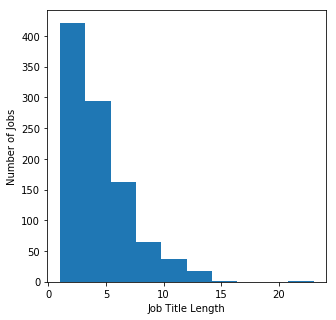

In [13]:
fig = plt.figure(figsize=(5, 5)) 
plt.xlabel('Job Title Length')
plt.ylabel('Number of Jobs')
plt.hist(title_lengths)
plt.show()

## Vectorize the tokens

We have several options when representing the tokenized words mathematically:

+ Bag of words -- count how many times a word appears 
+ tf-idf (term frequency-inverse document frequency) - assign weight by relevance of word, not frequency

### Processing tools

Convert data and target to list format for later use.

Define a function to create document-term matrix and fit a vectorizer model. Allow for multiple vectorizer options.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# create lists of X and y for later use
list_corpus = data['job_title'].tolist()
list_labels = data['class_label'].tolist()

def fit_vectorizer(data, vec_type='count'):
    '''Create and fit a vectorizer
    
    Options:
    + count -> count_vectorizer 
    + tfidf -> tfidf_vectorizer
    
    Input:
    + data - X data to fit the model
    + vec_type - name of vectorizer to use
    
    Returns:
    + Document-term matrix or Tf-idf-weighted document-term matrix
    + vectorizer - fitted model
    '''
    if vec_type=='count':
        vectorizer = CountVectorizer()
    elif vec_type=='tfidf':
        vectorizer = TfidfVectorizer()
    else:
        print('Please select an appropriate option')
    
    emb = vectorizer.fit_transform(data)

    return emb, vectorizer

### Evaluation & Vizualization tools

Some functions to help assess model performance.

In [11]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name, save_png=False):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5, color='r')
    plt.title('Skilled Position', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5, color='b')
    plt.title('Gig Job', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    if save_png:
        plt.savefig('../images/important_words.png')
    else:
        plt.show()

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

### Bag of Words

In [13]:
## run a 10-fold stratified cross validation

skf = StratifiedKFold(n_splits=10, random_state=0)

X = data['job_title']
y = data['class_label']

current_split = 1
acc_list = []; prec_list = []; rec_list = []
for train_index, test_index in skf.split(X, y):
    print('CURRENT SPLIT:', current_split)
    
    # get splits & assign data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # vectorize word counts
    X_train_counts, count_vectorizer = fit_vectorizer(X_train, vec_type='count')
    X_test_counts = count_vectorizer.transform(X_test)
    
    # train & test logsitic regression model
    clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='ovr', n_jobs=-1, random_state=40)
    clf.fit(X_train_counts, y_train)
    y_predicted = clf.predict(X_test_counts)
    # check performance
    accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
    print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
    
    # add metrics to list
    acc_list.append(accuracy)
    prec_list.append(precision)
    rec_list.append(recall)
    current_split += 1

# Sample classification report
cr = classification_report(y_test, y_predicted, labels=[0,1], target_names=['Regular Job', 'Gig'])
cm = confusion_matrix(y_test, y_predicted)

print('\nClassification Report')
print(cr)
print('\nConfusion Matrix')
print(cm)
    
# Summarize
print('\nFinal Perfomance')
print('Accuracy: mean %.3f, variance %.3f' % (np.mean(acc_list), np.var(acc_list)))
print('Precision: mean %.3f, variance %.3f' % (np.mean(prec_list), np.var(prec_list)))
print('Recall: mean %.3f, variance %.3f'% (np.mean(rec_list), np.var(rec_list)))

CURRENT SPLIT: 1
accuracy = 0.911, precision = 0.910, recall = 0.911, f1 = 0.910
CURRENT SPLIT: 2
accuracy = 0.931, precision = 0.932, recall = 0.931, f1 = 0.931
CURRENT SPLIT: 3
accuracy = 0.851, precision = 0.849, recall = 0.851, f1 = 0.850
CURRENT SPLIT: 4
accuracy = 0.910, precision = 0.916, recall = 0.910, f1 = 0.912
CURRENT SPLIT: 5
accuracy = 0.940, precision = 0.940, recall = 0.940, f1 = 0.940
CURRENT SPLIT: 6
accuracy = 0.900, precision = 0.897, recall = 0.900, f1 = 0.898
CURRENT SPLIT: 7
accuracy = 0.920, precision = 0.924, recall = 0.920, f1 = 0.921
CURRENT SPLIT: 8
accuracy = 0.899, precision = 0.933, recall = 0.899, f1 = 0.906
CURRENT SPLIT: 9
accuracy = 0.909, precision = 0.911, recall = 0.909, f1 = 0.910
CURRENT SPLIT: 10
accuracy = 0.869, precision = 0.884, recall = 0.869, f1 = 0.874

Classification Report
             precision    recall  f1-score   support

Regular Job       0.95      0.89      0.92        79
        Gig       0.64      0.80      0.71        20

avg /

This is promising so far. But it would help to have a better understanding of how the model is making its decisions. We can take a look at what the most important words are for determining whether a job is labeled as a gig-role and which words are less associated with it

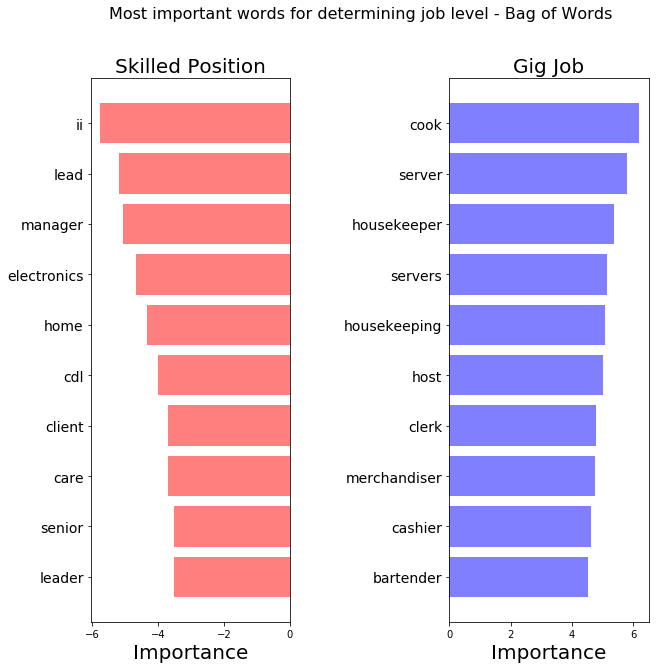

In [14]:
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

# vectorize word counts
X_train_counts, count_vectorizer = fit_vectorizer(X_train, vec_type='count')
X_test_counts = count_vectorizer.transform(X_test)
    
# train & test logsitic regression model
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='ovr', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

# get word importance
importance = get_most_important_features(count_vectorizer, clf, 10)

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for determining job level - Bag of Words")

## TF-IDF Model

In [15]:
## run a 10-fold stratified cross validation

skf = StratifiedKFold(n_splits=10, random_state=0)

X = data['job_title']
y = data['class_label']

current_split = 1
acc_list = []; prec_list = []; rec_list = []
for train_index, test_index in skf.split(X, y):
    print('CURRENT SPLIT:', current_split)
    
    # get splits & assign data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # vectorize word counts
    X_train_counts, tfidf_vectorizer = fit_vectorizer(X_train, vec_type='tfidf')
    X_test_counts = tfidf_vectorizer.transform(X_test)
    
    # train & test logsitic regression model
    clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='ovr', n_jobs=-1, random_state=40)
    clf.fit(X_train_counts, y_train)
    y_predicted = clf.predict(X_test_counts)
    # check performance
    accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
    print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
    
    # add metrics to list
    acc_list.append(accuracy)
    prec_list.append(precision)
    rec_list.append(recall)
    current_split += 1

# Sample classification report
cr = classification_report(y_test, y_predicted, labels=[0,1], target_names=['Regular Job', 'Gig'])
cm = confusion_matrix(y_test, y_predicted)

print('\nClassification Report')
print(cr)
print('\nConfusion Matrix')
print(cm)
    
# Summarize
print('\nFinal Perfomance')
print('Accuracy: mean %.3f, variance %.3f' % (np.mean(acc_list), np.var(acc_list)))
print('Precision: mean %.3f, variance %.3f' % (np.mean(prec_list), np.var(prec_list)))
print('Recall: mean %.3f, variance %.3f'% (np.mean(rec_list), np.var(rec_list)))

CURRENT SPLIT: 1
accuracy = 0.921, precision = 0.919, recall = 0.921, f1 = 0.918
CURRENT SPLIT: 2
accuracy = 0.921, precision = 0.924, recall = 0.921, f1 = 0.922
CURRENT SPLIT: 3
accuracy = 0.832, precision = 0.835, recall = 0.832, f1 = 0.833
CURRENT SPLIT: 4
accuracy = 0.920, precision = 0.929, recall = 0.920, f1 = 0.922
CURRENT SPLIT: 5
accuracy = 0.940, precision = 0.940, recall = 0.940, f1 = 0.940
CURRENT SPLIT: 6
accuracy = 0.910, precision = 0.909, recall = 0.910, f1 = 0.909
CURRENT SPLIT: 7
accuracy = 0.930, precision = 0.931, recall = 0.930, f1 = 0.931
CURRENT SPLIT: 8
accuracy = 0.939, precision = 0.953, recall = 0.939, f1 = 0.942
CURRENT SPLIT: 9
accuracy = 0.929, precision = 0.928, recall = 0.929, f1 = 0.929
CURRENT SPLIT: 10
accuracy = 0.879, precision = 0.890, recall = 0.879, f1 = 0.883

Classification Report
             precision    recall  f1-score   support

Regular Job       0.95      0.90      0.92        79
        Gig       0.67      0.80      0.73        20

avg /

Most important words for the tf-idf model

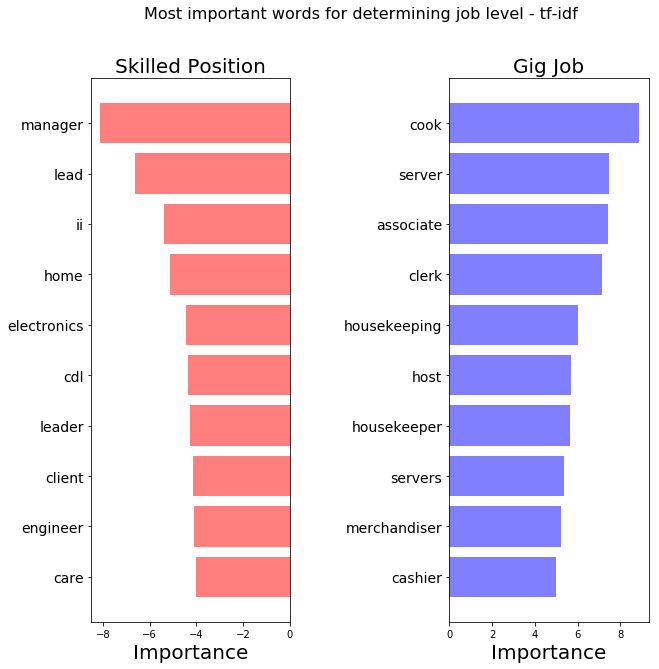

In [16]:
# retrain the model with full dataset
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

# vectorize word counts
X_train_counts, tfidf_vectorizer = fit_vectorizer(X_train, vec_type='tfidf')
X_test_counts = tfidf_vectorizer.transform(X_test)
    
# train & test logsitic regression model
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='ovr', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

# get word importance
importance = get_most_important_features(tfidf_vectorizer, clf, 10)

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for determining job level - tf-idf")

If we are happy with the performance of our model, we can retrain it on the entire labeled dataset and use it in production. The model used on our servers to classify jobs daily has undergone more testing and tuning. This one is simplified for clarity and demonstration.

In [ ]:
#filename = '../models/model_name.pckl'
#pickle.dump(model, open(filename, 'wb'))
  
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

## Conclusion

It appears from this first trial, both bag of words and tf-idf approaches perform fairly well on our data. However, a more carefully constructed model should be developed for production environments.